In [ ]:
#Loading the FireRisk dataset from drive
from google.colab import drive
drive.mount('/content/drive')

'''# Unzipping the data into Colab
!unzip -q "/content/drive/MyDrive/FireRisk.zip" -d "/content/dataset"

# Now pointing the PyTorch loader to the unzipped folder
data_dir= '/content/dataset'''
# The -n flag skips existing files so it won't get stuck asking to overwrite
!unzip -n -q "/content/drive/My Drive/firerisk_data.zip" -d "/content/dataset"

print("Unzip finished!")

NotImplementedError: Mounting drive is unsupported in this environment. Use PyDrive2 instead. See examples at https://colab.research.google.com/notebooks/io.ipynb#scrollTo=7taylj9wpsA2.

In [ ]:
import os

# List all zip files in your main Drive folder to find the right name
print("Searching for zip files in 'My Drive'...")
drive_path = "/content/drive/My Drive"
found_files = [f for f in os.listdir(drive_path) if f.endswith('.zip')]

for f in found_files:
    print(f"Found: {f}")

if not found_files:
    print("\n⚠️ No zip files found in the root of My Drive.")
    print("Please check if the file is inside a subfolder.")

Searching for zip files in 'My Drive'...
Found: DsResearch.zip
Found: FireRisk.zip


In [ ]:
# UPDATE THIS LINE with the exact name you found above
zip_filename = "FireRisk.zip"  # <--- Change this to your actual filename

# ---------------------------------------------------------
import os

# The path to your zip file
zip_path = f"/content/drive/My Drive/{zip_filename}"
# The folder where we want the images
extract_path = "/content/dataset"

print(f"Attempting to unzip: {zip_path}")

# Check if file exists before running
if os.path.exists(zip_path):
    # -n: skip existing files (don't ask to overwrite)
    # -q: quiet mode
    os.system(f'unzip -n -q "{zip_path}" -d "{extract_path}"')
    print("✅ Unzip finished!")
else:
    print("❌ ERROR: File still not found. Check the filename again.")

# Check how many images we have now
count = 0
for root, dirs, files in os.walk(extract_path):
    count += len(files)
print(f"Total files in dataset now: {count}")

Attempting to unzip: /content/drive/My Drive/FireRisk.zip
✅ Unzip finished!
Total files in dataset now: 91874


In [ ]:
import os
import shutil
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# 1. DELETE THE BAD FOLDER
bad_folder = "/content/dataset/__MACOSX"
if os.path.exists(bad_folder):
    shutil.rmtree(bad_folder)
    print("✅ Deleted '__MACOSX' folder.")
else:
    print("✅ '__MACOSX' folder is already gone.")

# 2. LOAD THE DATA
print("🔄 Loading data...")
transform = transforms.Compose([
    transforms.Resize((270, 270)), # Size from the paper
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Use the path where your data actually is
data_path = "/kaggle/input/firerisk/firerisk2434/FireRisk"

try:
    # Check if 'train' exists inside 'dataset'
    if os.path.exists(os.path.join(data_path, 'train')):
        train_ds = datasets.ImageFolder(os.path.join(data_path, 'train'), transform=transform)
        val_ds = datasets.ImageFolder(os.path.join(data_path, 'val'), transform=transform)
    else:
        # Otherwise, load from root and split
        full_ds = datasets.ImageFolder(data_path, transform=transform)
        train_size = int(0.8 * len(full_ds))
        val_size = len(full_ds) - train_size
        train_ds, val_ds = random_split(full_ds, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)
    print(f"🎉 Success! Loaded {len(train_ds)} training images.")

except Exception as e:
    print(f"❌ Error: {e}")

✅ '__MACOSX' folder is already gone.
🔄 Loading data...
🎉 Success! Loaded 70331 training images.


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

data_path = "/kaggle/input/firerisk/firerisk2434/FireRisk"

# Define Transforms (270x270 as per paper)
transform = transforms.Compose([
    transforms.Resize((270, 270)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Re-create DataLoaders
try:
    if os.path.exists(os.path.join(data_path, 'train')):
        train_ds = datasets.ImageFolder(os.path.join(data_path, 'train'), transform=transform)
        val_ds = datasets.ImageFolder(os.path.join(data_path, 'val'), transform=transform)
    else:
        # Fallback if no train/val folders
        full_ds = datasets.ImageFolder(data_path, transform=transform)
        train_size = int(0.8 * len(full_ds))
        val_size = len(full_ds) - train_size
        train_ds, val_ds = random_split(full_ds, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)
    print(f"✅ DataLoaders Ready: {len(train_ds)} Train, {len(val_ds)} Val images.")
except Exception as e:
    print(f"❌ Error loading data: {e}")


✅ DataLoaders Ready: 70331 Train, 21541 Val images.


In [ ]:
import torch
import torch.nn as nn

class block(nn.Module):
  def __init__(self,in_channels,out_channels,identity_downsample=None,stride=1):
    super(block,self).__init__()
    self.expansion=1
    self.conv1= nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1)
    self.bn1=nn.BatchNorm2d(out_channels)
    self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1)
    self.bn2=nn.BatchNorm2d(out_channels)
    '''self.conv3=nn.Conv2d(out_channels,out_channels * self.expansion,kernel_size=1,padding=0)
    self.bn3=nn.BatchNorm2d(out_channels*self.expansion)'''
    self.relu=nn.ReLU()
    self.identity_downsample=identity_downsample

  def forward(self,x):
    identity = x

    x=self.conv1(x)
    x=self.bn1(x)
    x=self.relu(x)
    x=self.conv2(x)
    x=self.bn2(x)
    #x=self.relu(x)
    '''x=self.conv3(x)
    x=self.bn3(x)'''

    if self.identity_downsample is not None:
      identity = self.identity_downsample(identity)

    #the important part where y=H(x)+x
    x+= identity
    x=self.relu(x)
    return x

class ResNet(nn.Module):
  def __init__(self,block,layers,image_channels,num_classes):
    super(ResNet,self).__init__()
    self.in_channels = 64
    self.conv1 = nn.Conv2d(image_channels,64,kernel_size=7,stride=2,padding=3)
    self.bn1=nn.BatchNorm2d(64)
    self.relu=nn.ReLU()
    self.maxpool=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

    #ResNet Layers
    self.layer1=self._make_layer(block,layers[0],out_channels=64,stride=1)
    self.layer2=self._make_layer(block,layers[1],out_channels=128,stride=2)
    self.layer3=self._make_layer(block,layers[2],out_channels=256,stride=2)
    self.layer4=self._make_layer(block,layers[3],out_channels=512,stride=2)

    self.avgpool=nn.AdaptiveAvgPool2d((1,1))
    self.fc=nn.Linear(512,num_classes)

  def forward(self,x):
    x=self.conv1(x)
    x=self.bn1(x)
    x=self.relu(x)
    x=self.maxpool(x)

    x=self.layer1(x)
    x=self.layer2(x)
    x=self.layer3(x)
    x=self.layer4(x)

    x=self.avgpool(x)
    x=x.reshape(x.shape[0],-1)
    x=self.fc(x)

    return x



  def _make_layer(self,block,num_residual_blocks, out_channels,stride):
    identity_downsample=None
    layers=[]

    if stride != 1 or ((self.in_channels) != (out_channels)):
      identity_downsample=nn.Sequential(nn.Conv2d(self.in_channels,out_channels,kernel_size=1,stride=stride),nn.BatchNorm2d(out_channels))

    layers.append(block(self.in_channels,out_channels,identity_downsample,stride))
    self.in_channels=out_channels

    for i in range(num_residual_blocks-1):
      layers.append(block(self.in_channels,out_channels,identity_downsample=None,stride=1))

    return nn.Sequential(*layers)

def ResNet18(img_channels=3,num_classes=1000):
    return ResNet(block,[2,2,2,2],img_channels,num_classes)

def test():
  device= 'cuda' if torch.cuda.is_available() else 'cpu'
  net = ResNet18().to(device)
  x=torch.randn(2,3,224,224)
  x=x.to(device)
  y=net(x).to(device)
  print(y.shape)

test()

torch.Size([2, 1000])


 Starting training for 15 epochs...

Epoch 1/15


  0%|          | 0/2198 [00:00<?, ?it/s]

  Train loss: 1.3411
  Val accuracy: 52.56%
New best model saved!(52.56%)

Epoch 2/15


  0%|          | 0/2198 [00:00<?, ?it/s]

  Train loss: 1.2463
  Val accuracy: 48.63%

Epoch 3/15


  0%|          | 0/2198 [00:00<?, ?it/s]

  Train loss: 1.2007
  Val accuracy: 54.32%
New best model saved!(54.32%)

Epoch 4/15


  0%|          | 0/2198 [00:00<?, ?it/s]

  Train loss: 1.1756
  Val accuracy: 56.67%
New best model saved!(56.67%)

Epoch 5/15


  0%|          | 0/2198 [00:00<?, ?it/s]

  Train loss: 1.1519
  Val accuracy: 58.15%
New best model saved!(58.15%)

Epoch 6/15


  0%|          | 0/2198 [00:00<?, ?it/s]

  Train loss: 1.1315
  Val accuracy: 55.62%

Epoch 7/15


  0%|          | 0/2198 [00:00<?, ?it/s]

  Train loss: 1.1157
  Val accuracy: 56.02%

Epoch 8/15


  0%|          | 0/2198 [00:00<?, ?it/s]

  Train loss: 1.1021
  Val accuracy: 57.61%

Epoch 9/15


  0%|          | 0/2198 [00:00<?, ?it/s]

  Train loss: 1.0877
  Val accuracy: 57.11%

Epoch 10/15


  0%|          | 0/2198 [00:00<?, ?it/s]

  Train loss: 1.0755
  Val accuracy: 56.98%

Epoch 11/15


  0%|          | 0/2198 [00:00<?, ?it/s]

  Train loss: 1.0648
  Val accuracy: 57.35%

Epoch 12/15


  0%|          | 0/2198 [00:00<?, ?it/s]

  Train loss: 1.0522
  Val accuracy: 59.30%
New best model saved!(59.30%)

Epoch 13/15


  0%|          | 0/2198 [00:00<?, ?it/s]

  Train loss: 1.0404
  Val accuracy: 54.43%

Epoch 14/15


  0%|          | 0/2198 [00:00<?, ?it/s]

  Train loss: 1.0306
  Val accuracy: 57.25%

Epoch 15/15


  0%|          | 0/2198 [00:00<?, ?it/s]

  Train loss: 1.0150
  Val accuracy: 58.72%


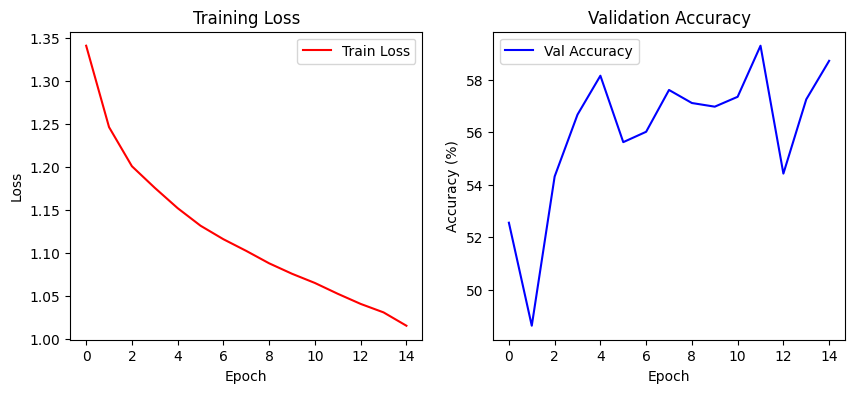

In [ ]:
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

device='cuda' if torch.cuda.is_available() else 'cpu'

# Hyperparameters
Learning_rate=0.001
Batch_size=32
num_epochs=15
num_classes=7

# Model Initializing
model=ResNet18(img_channels=3,num_classes=num_classes).to(device)

# Loss Func and Criterion
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=Learning_rate)

train_losses=[]
val_accuracies=[]

# Training pipleline
def train_one_epoch(loader,model,optimizer,criterion):
  model.train()
  running_loss=0.0
  loop=tqdm(loader,leave=False) # Progress bar for epoch

  for batch_idx,(data,targets) in enumerate(loop):
    data=data.to(device)
    targets=targets.to(device)

    # Forward
    scores=model(data)
    loss=criterion(scores,targets)

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # updating the weights

    running_loss += loss.item()
    loop.set_description(f"Train step")
    loop.set_postfix(loss=loss.item())
  return running_loss / len(loader)

# Accuracy Check
def check_accuracy(loader,model):
  model.eval()
  num_correct = 0
  num_samples = 0

  with torch.no_grad():
    for x,y in loader:
      x=x.to(device)
      y=y.to(device)

      scores=model(x)
      _,predictions = scores.max(1)
      num_correct += (predictions==y).sum().item()
      num_samples += predictions.size(0)

  acc=float(num_correct) / float(num_samples) * 100
  return acc

# Main loop
best_acc = 0.0
print(f" Starting training for {num_epochs} epochs...")
for epoch in range(num_epochs):
  print(f"\nEpoch {epoch+1}/{num_epochs}")
  #Train
  avg_train_loss= train_one_epoch(train_loader,model,optimizer,criterion)
  train_losses.append(avg_train_loss)
  # Validate
  current_acc = check_accuracy(val_loader, model)
  val_accuracies.append(current_acc)
  print(f"  Train loss: {avg_train_loss:.4f}")
  print(f"  Val accuracy: {current_acc:.2f}%")

  # Saving the Best Model for reuse
  if(current_acc > best_acc):
      best_acc = current_acc
      torch.save(model.state_dict(), "best_fire_risk_model_resnet18.pth")
      print(f"New best model saved!({best_acc:.2f}%)")


# Visualization
plt.figure(figsize=(10,4))

# Plot Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss',color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(val_accuracies,label='Val Accuracy', color='blue')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [ ]:
3